## Climate indicator comparisons

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
import matplotlib.lines as mlines

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
1,1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
2,2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
3,3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
4,4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722329,1722329,1722329,1805040,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722330,1722330,1722330,1805041,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722331,1722331,1722331,1805042,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0
1722332,1722332,1722332,1805043,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0


In [3]:
pd.unique(obs['current'])

array(['shelf', nan, 'CUC', 'CC'], dtype=object)

In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [5]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

/tmp/ipykernel_2420005/497193821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['dist'] = obs_cuc.NSdist
/tmp/ipykernel_2420005/497193821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf['dist'] = obs_shelf.NSdist
/tmp/ipykernel_2420005/497193821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

In [6]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index') # rearange df into 3x552 instead of 13x46
enso['month'] = enso['month'].astype(int) 
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


## Functions

In [64]:
def fft_lowpass_monthly(time, value, *, cutoff_period_months=12, keep_mean=True):
    """
    Low-pass filter via FFT:
      keeps variability with periods >= cutoff_period_months
      removes variability with periods < cutoff_period_months

    """
    # make dataframe
    d = {'time_col':time,'value_col':value}
    df = pd.DataFrame(d)

    # strictly-regular monthly series
    s = df.sort_values('time_col').set_index('time_col')['value_col'].copy()
    s = s.asfreq("MS")

    # original validity mask
    valid = ~s.isna()

    # fill gaps so FFT is defined
    # s_filled = s.interpolate("time", limit_area="inside")
    s_filled = s.interpolate("time", limit_direction="both")

    x = s_filled.to_numpy(dtype=float)
    n = x.size
    if n < 24:  # too short to explainably low-pass at 12 months
        return pd.Series(np.full(n, np.nan), index=s.index)

    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0)  # cycles per month (d=1 month)
    f_cut = 1.0 / float(cutoff_period_months)

    # keep only low frequencies: f <= f_cut  (period >= cutoff)
    keep = freqs <= f_cut
    if keep_mean:
        keep[0] = True

    Xf = X * keep
    y = np.fft.irfft(Xf, n=n)

    # restore original NaN mask (prevents n increasing)
    y[~valid] = np.nan

    return y


def decimal_year_monthstart_to_datetime(t_month):
    # get t_month into a date format that the filtering can handle
    t = np.asarray(t_month, float)
    years = np.floor(t).astype(int)
    months = (np.round((t - years) * 12).astype(int) + 1).clip(1, 12)
    return pd.to_datetime(
        {"year": years, "month": months, "day": np.ones_like(years)}
    )

In [69]:
# apply filtering to indices
enso['index_lp12'] = fft_lowpass_monthly(enso['time'],enso['index'])
npgo['index_lp12'] = fft_lowpass_monthly(npgo['time'],npgo['index'])
pdo['index_lp12']  = fft_lowpass_monthly(pdo['time'],pdo['index'])

In [47]:
# ---------- helpers ----------
def _ensure_numeric(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _bin_depth(depth_series, depth_edges): # not necessarily just for depth, can bin anything
    return pd.cut(depth_series, bins=depth_edges, right=False,
                  include_lowest=True, labels=False)

# ---------- statistics ----------
def _calc_stats(mean_anom, df2, t_month, lag_months=0):
    # 1. Make both series pandas Series with decimal-year index
    df2_series = pd.Series(df2['index_lp12'].values, index=df2['decimal_yr'])
    # shift anom series forward by lag months while you do so
    anom_series = pd.Series(mean_anom, index=t_month)
    anom_shifted_index = anom_series.index + (lag_months / 12.0)
    anom_series = pd.Series(anom_series.values, index=anom_shifted_index)

    # 2. Reindex to match the anomaly time base
    df2_aligned = df2_series.reindex(anom_series.index, method='nearest', tolerance=1/52)
    # tolerance=1/52 ~ ±1 weeks in decimal-year units

    # 3. Drop NaNs (if df2 doesn't cover full range)
    mask = ~df2_aligned.isna() & ~anom_series.isna()
    df2_matched = df2_aligned[mask].values
    anom_matched = anom_series[mask].values

    stats = {}
    stats['r'] = pearsonr(anom_matched,df2_matched).statistic
    stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
    stats['n'] = int(mask.sum())
    
    return stats

def _find_best_lag(mean_anom, t_month, df2, max_lag_months=6):
    """
    Scan forward lags k = 0..max_lag_months (months) and return the lag with max |r|.

    Returns
    -------
    best : dict
        {'best_lag_months','r','pvalue','n','r_by_lag','p_by_lag'}
    """
    r_by_lag = []
    p_by_lag = []
    n_by_lag = []

    for k in range(int(max_lag_months) + 1):
        stats = _calc_stats(mean_anom, df2, t_month, lag_months=k)
        r_by_lag.append(stats['r'])
        p_by_lag.append(stats['pvalue'])
        n_by_lag.append(stats['n'])

    r_arr = np.asarray(r_by_lag, float)
    # choose by maximum absolute correlation; if you prefer positive only, drop abs()
    if np.all(np.isnan(r_arr)):
        return {'best_lag_months': np.nan, 'r': np.nan, 'pvalue': np.nan, 'n': 0}

    kbest = int(np.nanargmax(np.abs(r_arr)))
    return {'best_lag_months': kbest, 'r': r_arr[kbest], 'pvalue': p_by_lag[kbest], 'n': n_by_lag[kbest]}

def plot_panel(ax, mean_anom, df2, t_month, max_lag_months=6,colour='k',xloc=0,yloc=0.82):
    best = _find_best_lag(mean_anom, t_month, df2, max_lag_months=max_lag_months)

    statstext = (f"Lag = {best['best_lag_months']} mo, n = {best['n']}\n"
                 f"r = {best['r']:.2f}  (p = {best['pvalue']:.3f})")

    props = dict(boxstyle='round', facecolor='w',edgecolor=colour, alpha=0.7)
    c = ax.text(xloc, yloc, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    return c

# ---------- monthly lat-binned means ----------
def avg_profile_12months_dist(obs_used, dist_edges, variable_str, return_counts=False):
    s = _ensure_numeric(obs_used, [variable_str, 'latitude (degrees_north)', 'month'])
    s = s.dropna(subset=[variable_str, 'latitude (degrees_north)', 'month']).copy()
    s['_month'] = s['month'].astype(int)
    s['_zbin'] = _bin_depth(s['latitude (degrees_north)'], dist_edges)

    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(dist_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_dist_monthly(obs_used, start_yr, end_yr, dist_edges,
                               variable_str, base_period=None, min_samples_per_cell=3):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)
    nbins = len(dist_edges) - 1

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    clim_mean, clim_cnt = avg_profile_12months_dist(clim_obs, dist_edges,
                                                     variable_str, return_counts=True)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:
        m12, c12 = avg_profile_12months_dist(
            obs_used[obs_used['year'] == yr], dist_edges, variable_str, return_counts=True)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)
    clim_tiled = np.tile(clim_mean, (nyears, 1))

    anom = (yr_means - clim_tiled).T
    mask = (yr_counts.T >= min_samples_per_cell)
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom, t_month


## Tables

In [ ]:
base_period = (1991, 2020)
obs_used = obs_shelf.copy()

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

for variable_str in vars:
    print(variable_str)
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )

    time = decimal_year_monthstart_to_datetime(t_month)
    
    regions = ['Southern','Central','Northern']
    for i in range(len(regions)):
        print(regions[i])
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, enso, max_lag_months=6)
        print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, pdo, max_lag_months=6)
        print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, npgo, max_lag_months=6)
        print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        print("\n")

temperature (degC)
Southern
ENSO & 0.55 & 0.000 & 0 & 222
PDO & 0.42 & 0.000 & 0 & 408
NPGO & -0.33 & 0.000 & 5 & 408


Central
ENSO & 0.46 & 0.000 & 0 & 174
PDO & 0.41 & 0.000 & 0 & 254
NPGO & -0.31 & 0.000 & 6 & 254


Northern
ENSO & 0.51 & 0.000 & 0 & 349
PDO & 0.40 & 0.000 & 0 & 355
NPGO & -0.27 & 0.000 & 5 & 347


salinity (g kg-1)
Southern
ENSO & -0.31 & 0.000 & 5 & 223
PDO & -0.21 & 0.000 & 0 & 408
NPGO & 0.07 & 0.176 & 3 & 408


Central
ENSO & -0.49 & 0.000 & 1 & 174
PDO & -0.36 & 0.000 & 0 & 256
NPGO & 0.29 & 0.000 & 5 & 256


Northern
ENSO & -0.06 & 0.270 & 0 & 371
PDO & -0.12 & 0.007 & 0 & 530
NPGO & 0.28 & 0.000 & 6 & 501


spice
Southern
ENSO & 0.44 & 0.000 & 0 & 222
PDO & 0.28 & 0.000 & 0 & 408
NPGO & -0.27 & 0.000 & 5 & 408


Central
ENSO & 0.26 & 0.000 & 0 & 174
PDO & 0.26 & 0.000 & 0 & 254
NPGO & -0.19 & 0.003 & 6 & 254


Northern
ENSO & 0.42 & 0.000 & 0 & 349
PDO & 0.34 & 0.000 & 2 & 354
NPGO & 0.13 & 0.014 & 1 & 351


DO (umol kg-1)
Southern
ENSO & 0.40 & 0.000 & 1 &

/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541111303.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541111303.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541

In [74]:
base_period = (1991, 2020)
obs_used = obs_cuc.copy()

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

for variable_str in vars:
    print(variable_str)
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )

    time = decimal_year_monthstart_to_datetime(t_month)
    
    regions = ['Southern','Central','Northern']
    for i in range(len(regions)):
        print(regions[i])
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, enso, max_lag_months=6)
        print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, pdo, max_lag_months=6)
        print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, npgo, max_lag_months=6)
        print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        print("\n")

temperature (degC)
Southern
ENSO & 0.13 & 0.051 & 1 & 224
PDO & 0.02 & 0.687 & 3 & 443
NPGO & -0.12 & 0.009 & 0 & 434


Central
ENSO & -0.04 & 0.618 & 6 & 157
PDO & 0.29 & 0.000 & 0 & 258
NPGO & 0.11 & 0.076 & 0 & 251


Northern
ENSO & 0.27 & 0.000 & 4 & 269
PDO & 0.11 & 0.071 & 5 & 286
NPGO & -0.36 & 0.000 & 5 & 283


salinity (g kg-1)
Southern
ENSO & 0.12 & 0.080 & 1 & 224
PDO & -0.03 & 0.480 & 0 & 443
NPGO & -0.12 & 0.010 & 0 & 434


Central
ENSO & -0.10 & 0.208 & 6 & 157
PDO & 0.30 & 0.000 & 0 & 258
NPGO & 0.08 & 0.199 & 4 & 254


Northern
ENSO & 0.17 & 0.006 & 6 & 268
PDO & 0.04 & 0.530 & 2 & 287
NPGO & -0.35 & 0.000 & 0 & 280


spice
Southern
ENSO & 0.13 & 0.059 & 1 & 224
PDO & -0.03 & 0.571 & 0 & 443
NPGO & -0.12 & 0.009 & 0 & 434


Central
ENSO & -0.07 & 0.403 & 6 & 157
PDO & 0.30 & 0.000 & 0 & 258
NPGO & 0.10 & 0.125 & 0 & 251


Northern
ENSO & 0.23 & 0.000 & 6 & 268
PDO & 0.07 & 0.239 & 5 & 286
NPGO & -0.36 & 0.000 & 4 & 282


DO (umol kg-1)
Southern
ENSO & 0.12 & 0.085 & 6 &

/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541111303.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541111303.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541

In [75]:
base_period = (1991, 2020)
obs_used = obs_cc.copy()

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

for variable_str in vars:
    print(variable_str)
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )

    time = decimal_year_monthstart_to_datetime(t_month)
    
    regions = ['Southern','Central','Northern']
    for i in range(len(regions)):
        print(regions[i])
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, enso, max_lag_months=6)
        print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, pdo, max_lag_months=6)
        print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        best = _find_best_lag(fft_lowpass_monthly(time,anom_array[i]), t_month, npgo, max_lag_months=6)
        print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
        print("\n")

temperature (degC)
Southern
ENSO & 0.48 & 0.000 & 0 & 230
PDO & 0.37 & 0.000 & 0 & 453
NPGO & -0.47 & 0.000 & 3 & 446


Central
ENSO & 0.38 & 0.023 & 0 & 36
PDO & 0.50 & 0.000 & 0 & 121
NPGO & -0.18 & 0.059 & 5 & 117


Northern
ENSO & 0.19 & 0.003 & 5 & 230
PDO & 0.18 & 0.004 & 0 & 264
NPGO & -0.13 & 0.033 & 4 & 255


salinity (g kg-1)
Southern
ENSO & -0.21 & 0.001 & 6 & 232
PDO & -0.06 & 0.194 & 3 & 453
NPGO & 0.04 & 0.455 & 6 & 449


Central
ENSO & 0.30 & 0.072 & 6 & 38
PDO & 0.41 & 0.000 & 6 & 121
NPGO & 0.18 & 0.057 & 6 & 118


Northern
ENSO & 0.16 & 0.015 & 0 & 231
PDO & 0.16 & 0.011 & 0 & 264
NPGO & 0.38 & 0.000 & 2 & 255


spice
Southern
ENSO & 0.29 & 0.000 & 0 & 230
PDO & 0.24 & 0.000 & 0 & 453
NPGO & -0.32 & 0.000 & 3 & 446


Central
ENSO & 0.48 & 0.003 & 3 & 36
PDO & 0.60 & 0.000 & 0 & 121
NPGO & 0.06 & 0.526 & 0 & 116


Northern
ENSO & 0.19 & 0.003 & 0 & 231
PDO & 0.20 & 0.001 & 0 & 264
NPGO & 0.15 & 0.015 & 0 & 256


DO (umol kg-1)
Southern
ENSO & 0.29 & 0.000 & 6 & 209
PDO

/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541111303.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541111303.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2420005/541111303.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2420005/541

## Summary Plots

<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2420005/1703905765.py:100: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2420005/1703905765.py:100: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ (

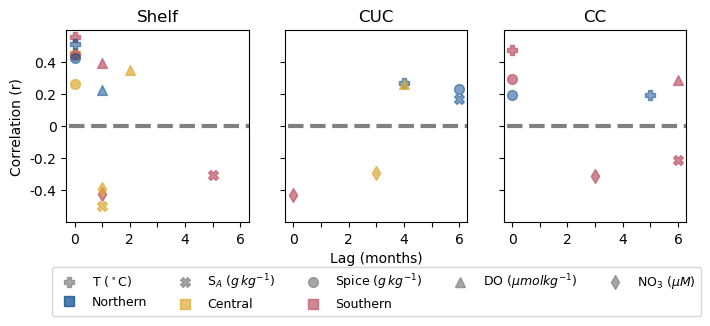

In [78]:
base_period = (1991, 2020)

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, enso, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')



<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2420005/1241271933.py:100: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2420005/1241271933.py:100: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ (

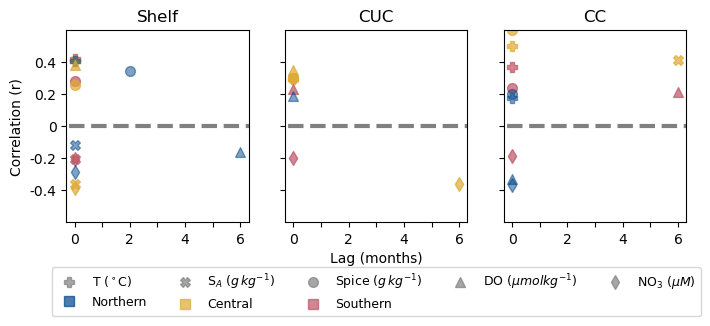

In [79]:
base_period = (1991, 2020)

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, pdo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/pdo.png', bbox_inches='tight')


<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\m'
<>:100: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2420005/1439261108.py:100: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2420005/1439261108.py:100: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ (

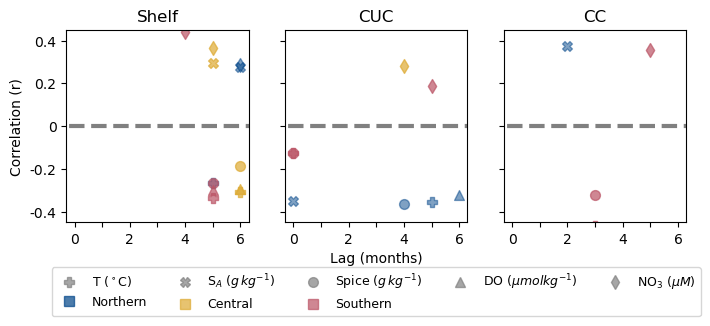

In [80]:
base_period = (1991, 2020)

vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.45,0.45])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[vars[i]])])
    dist_edges = [min_dist-0.1,34.45,40.44,max_dist+0.1]

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[0]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[1]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
    best = _find_best_lag(fft_lowpass_monthly(time,anom_array[2]), t_month, npgo, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >100:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/npgo.png', bbox_inches='tight')


## Latitude Anomaly Plots
### Temperature

<>:73: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:231: SyntaxWarning: invalid escape sequence '\c'
<>:73: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:231: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2420005/346500412.py:73: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/346500412.py:152: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/346500412.py:231: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


(1995.0, 2024.0)

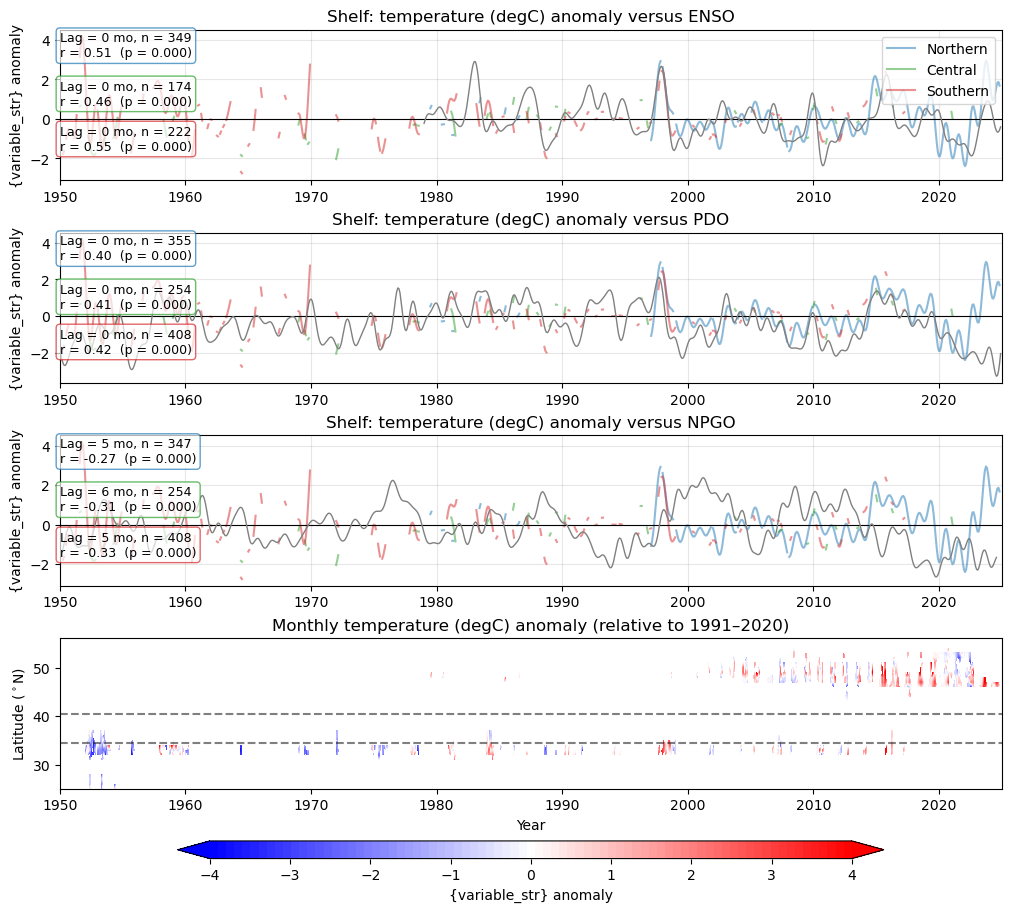

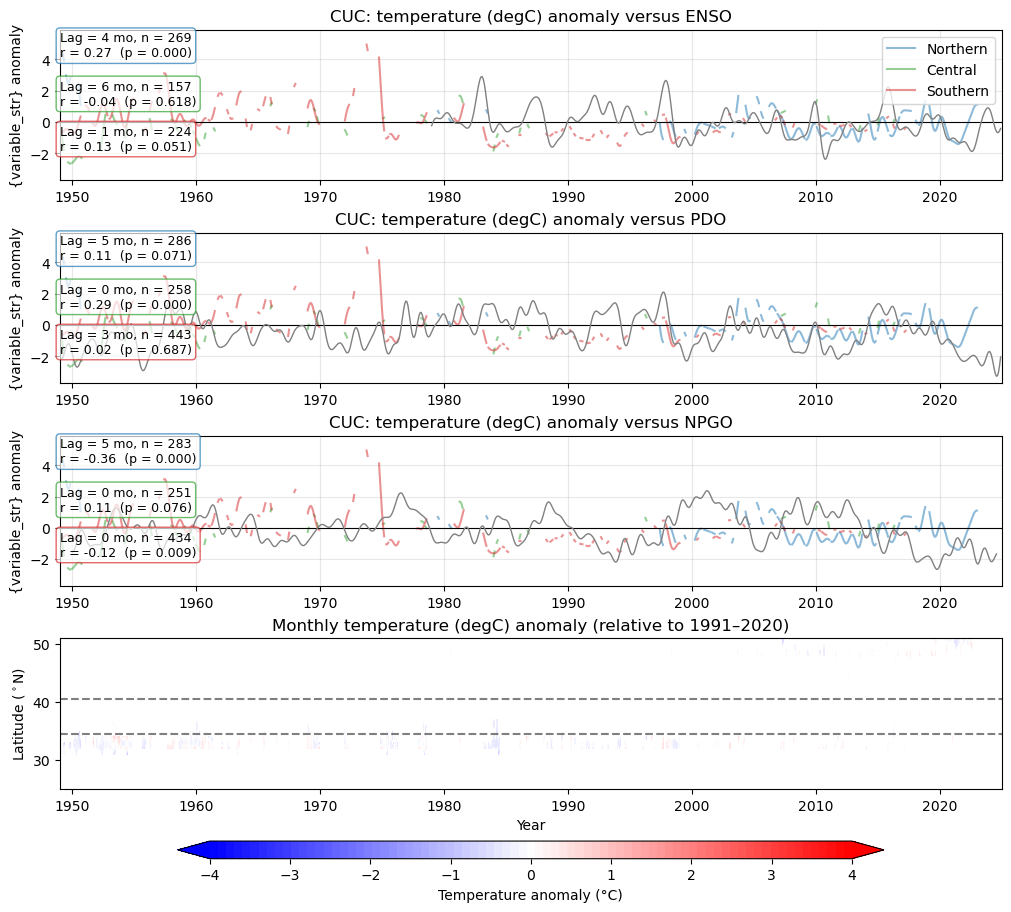

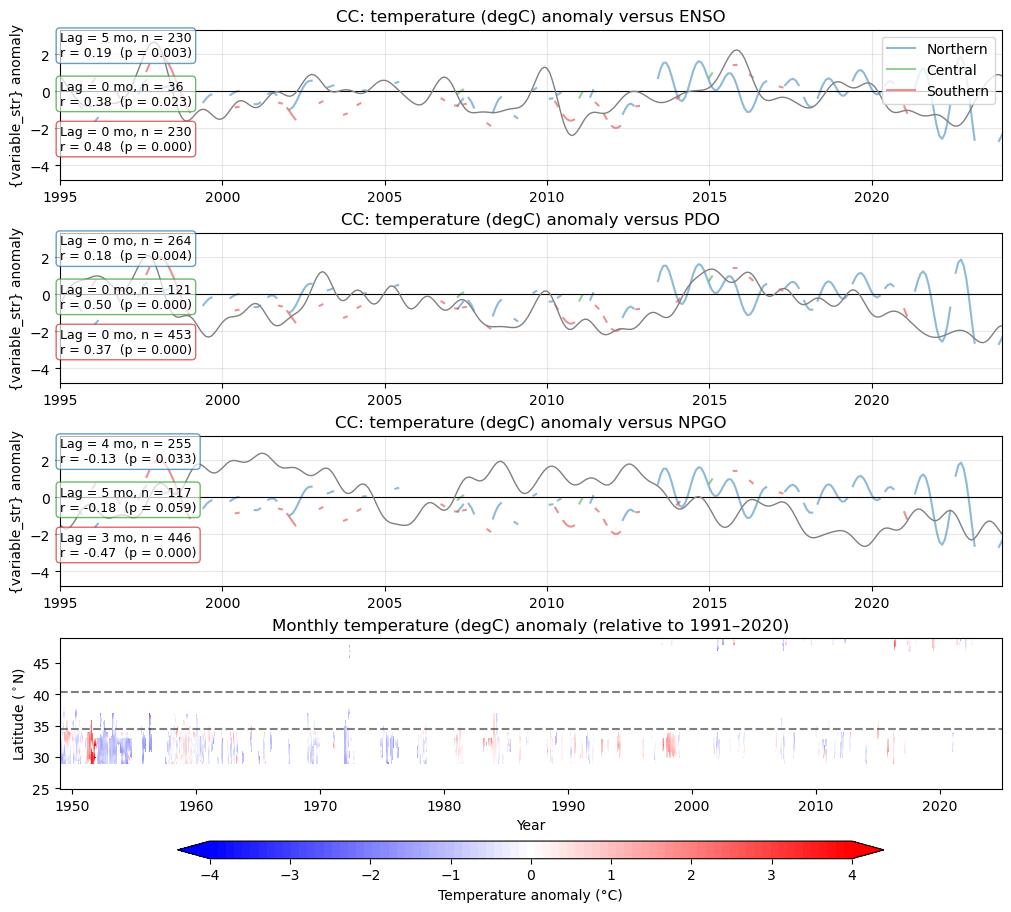

In [85]:
#############
#-- Shelf --#
#############

obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('{variable_str} anomaly')


#############
#--- CUC ---#
#############

obs_used = obs_cuc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')
# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


##############
#---- CC ----#
##############
obs_used = obs_cc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')

ax[0].set_xlim([1995,2024])
ax[1].set_xlim([1995,2024])
ax[2].set_xlim([1995,2024])
# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NorthTAnom.png')



### Salinity

<>:74: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
<>:74: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2420005/3456887180.py:74: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/3456887180.py:152: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/3456887180.py:230: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


(1995.0, 2024.0)

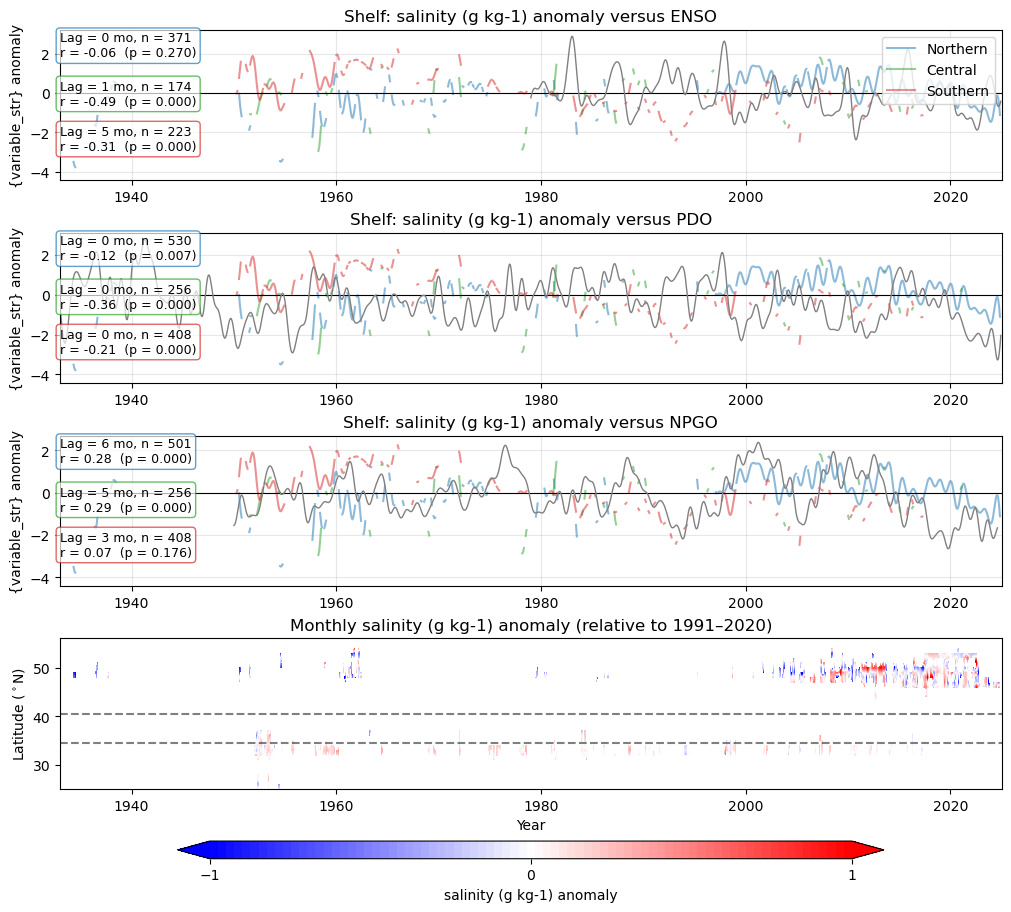

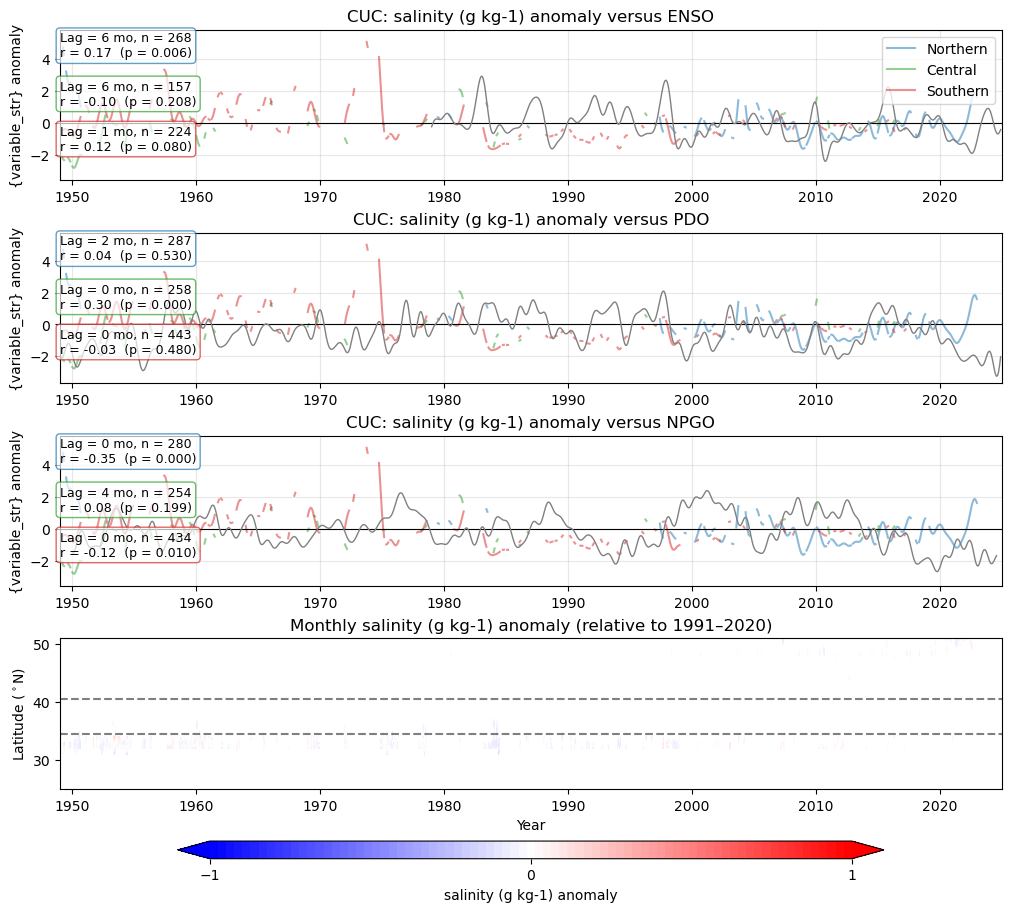

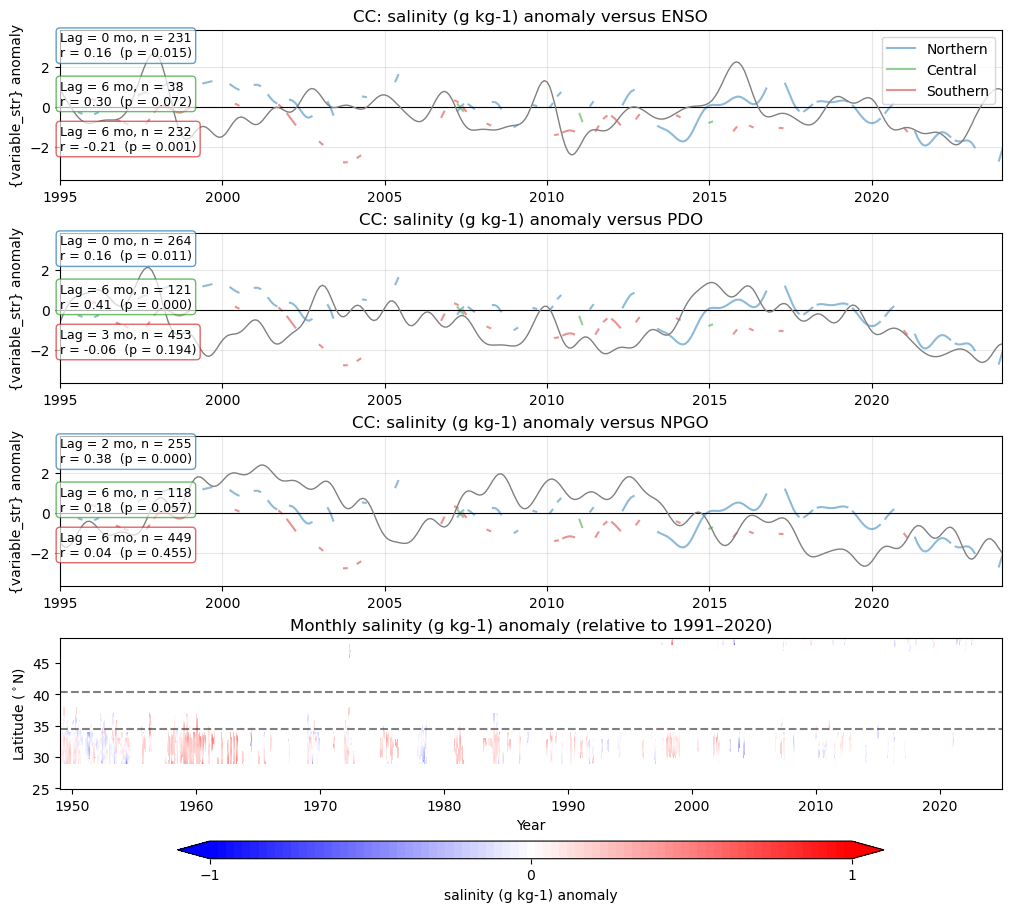

In [89]:
#############
#-- Shelf --#
#############

obs_used = obs_shelf.copy()
variable_str = 'salinity (g kg-1)'
vmax = 1

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")


#############
#--- CUC ---#
#############

obs_used = obs_cuc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')
# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")


##############
#---- CC ----#
##############
obs_used = obs_cc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")

ax[0].set_xlim([1995,2024])
ax[1].set_xlim([1995,2024])
ax[2].set_xlim([1995,2024])
# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NorthTAnom.png')



### DO

<>:74: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
<>:74: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2420005/1968143265.py:74: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/1968143265.py:152: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/1968143265.py:230: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


(1995.0, 2024.0)

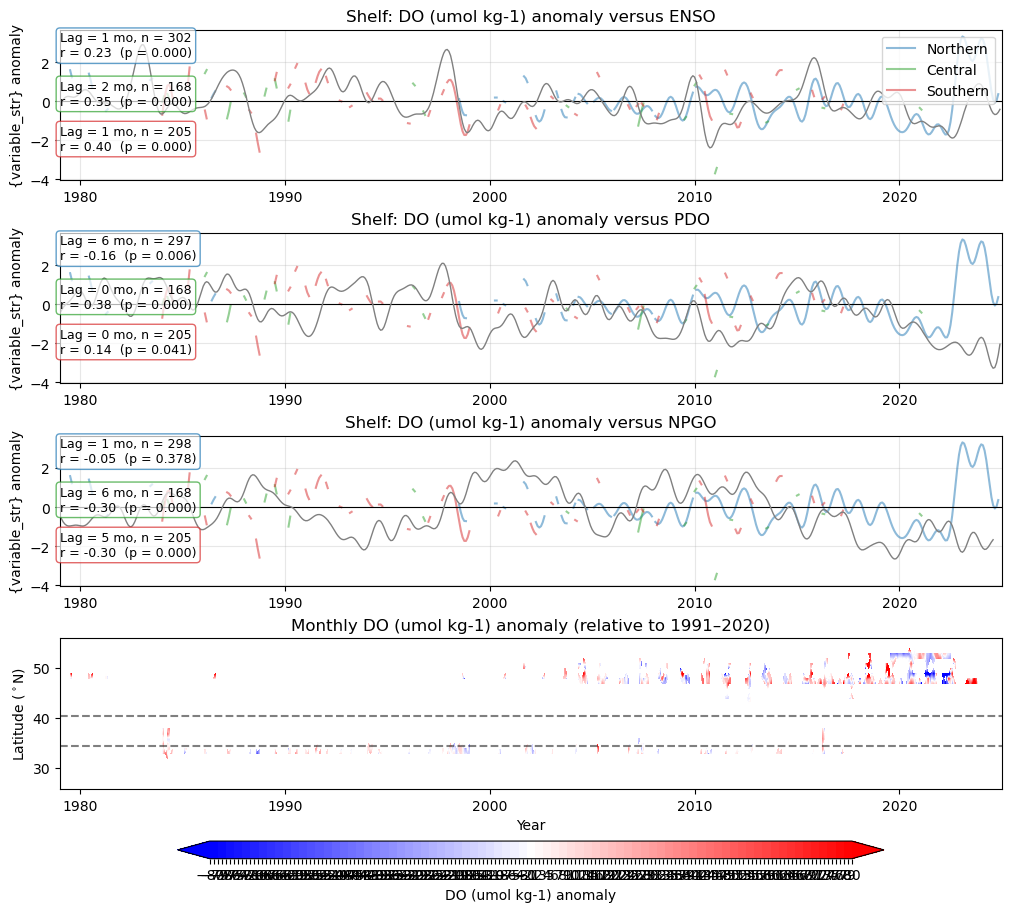

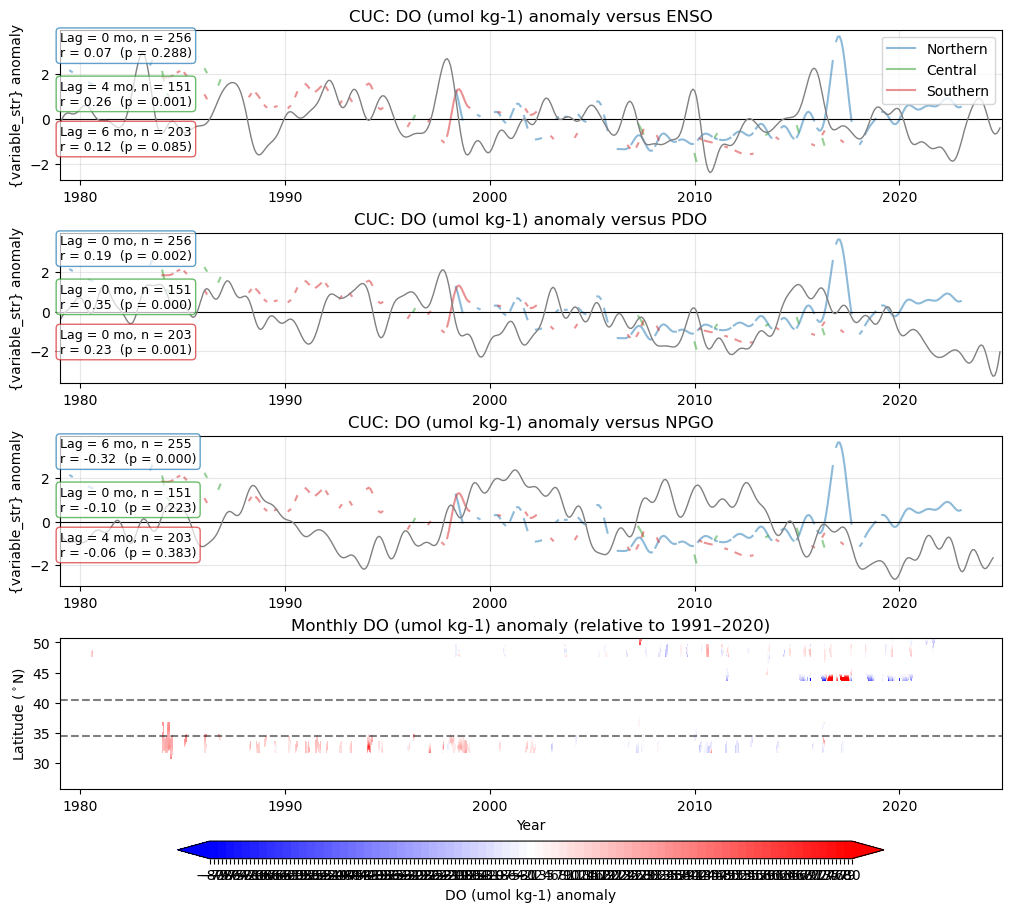

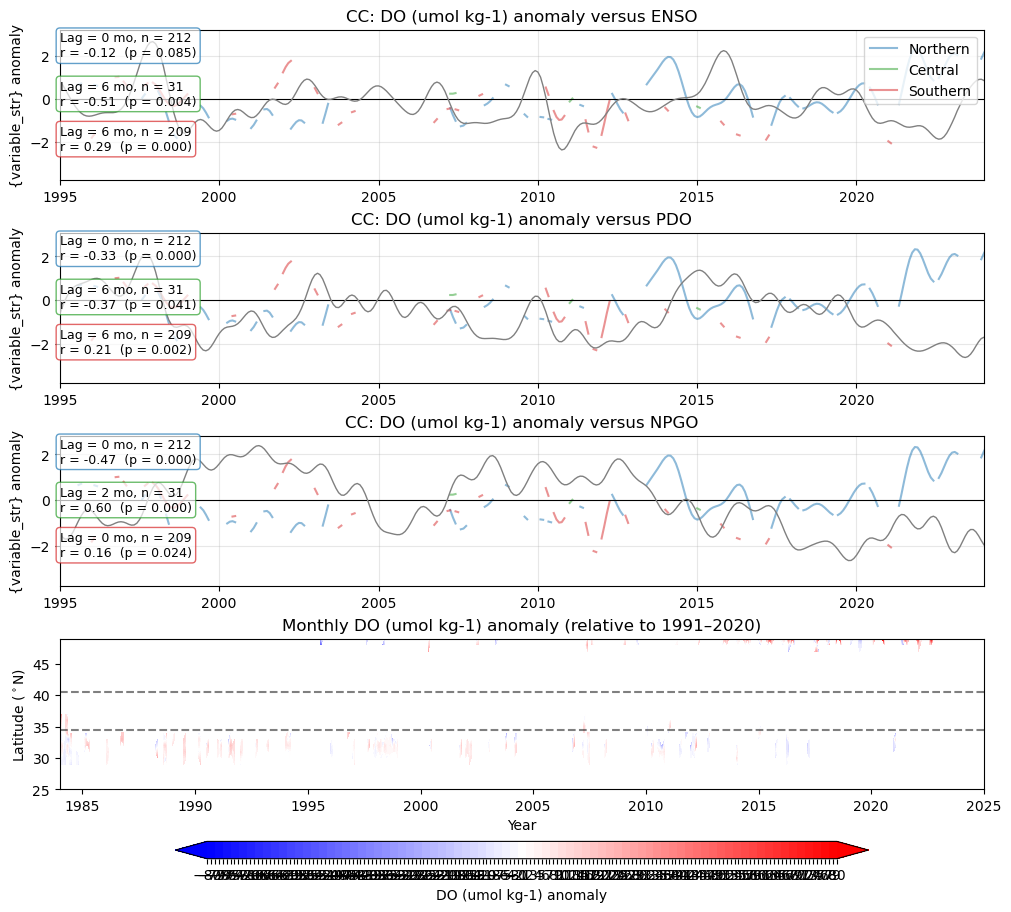

In [90]:
#############
#-- Shelf --#
#############

obs_used = obs_shelf.copy()
variable_str = 'DO (umol kg-1)'
vmax = 80

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")


#############
#--- CUC ---#
#############

obs_used = obs_cuc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')
# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")


##############
#---- CC ----#
##############
obs_used = obs_cc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")

ax[0].set_xlim([1995,2024])
ax[1].set_xlim([1995,2024])
ax[2].set_xlim([1995,2024])
# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NorthTAnom.png')



### NO3

<>:74: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
<>:74: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2420005/2523888891.py:74: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/2523888891.py:152: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')
/tmp/ipykernel_2420005/2523888891.py:230: SyntaxWarning: invalid escape sequence '\c'
  ax[3].set_ylabel('Latitude ($^\circ$N)')


(1995.0, 2024.0)

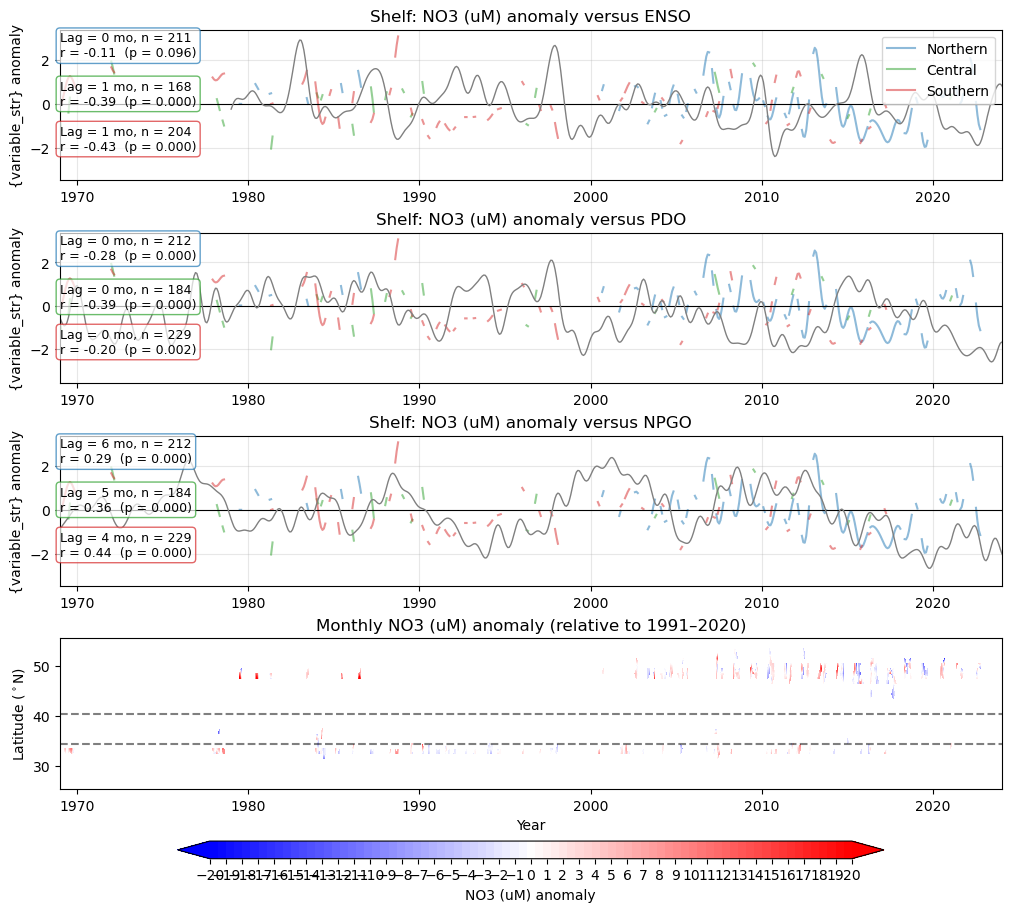

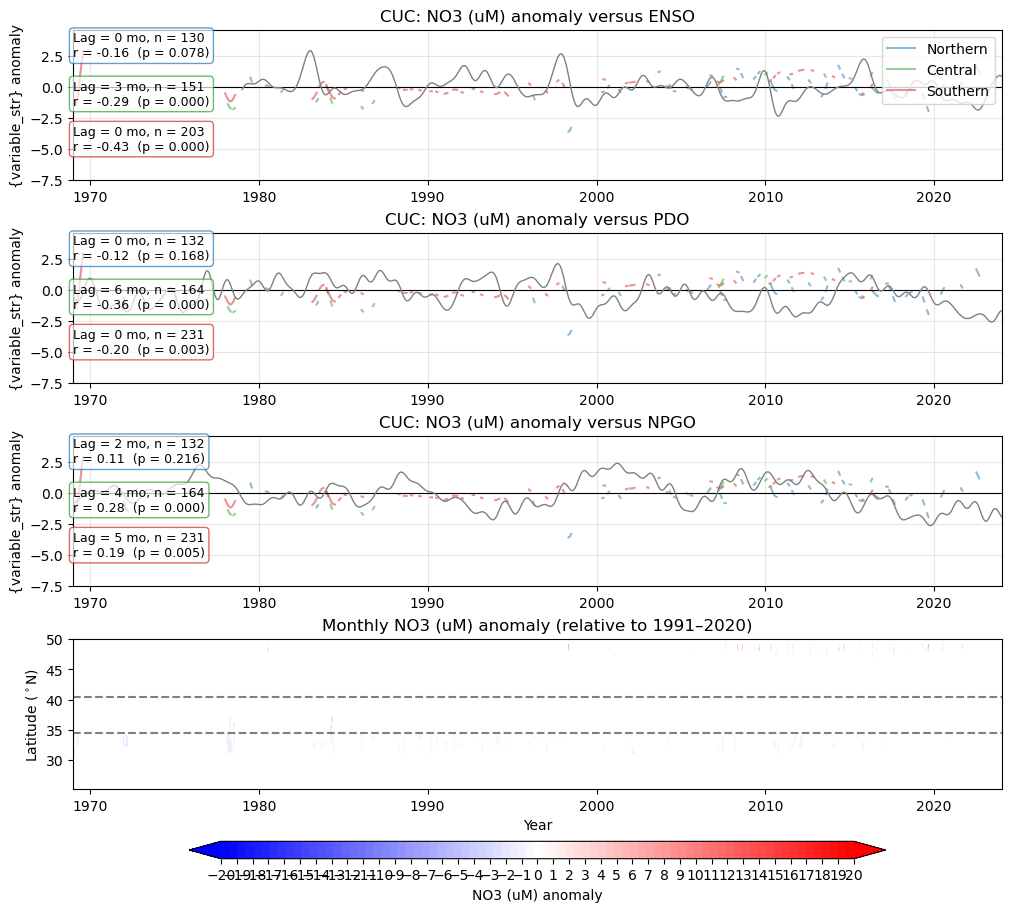

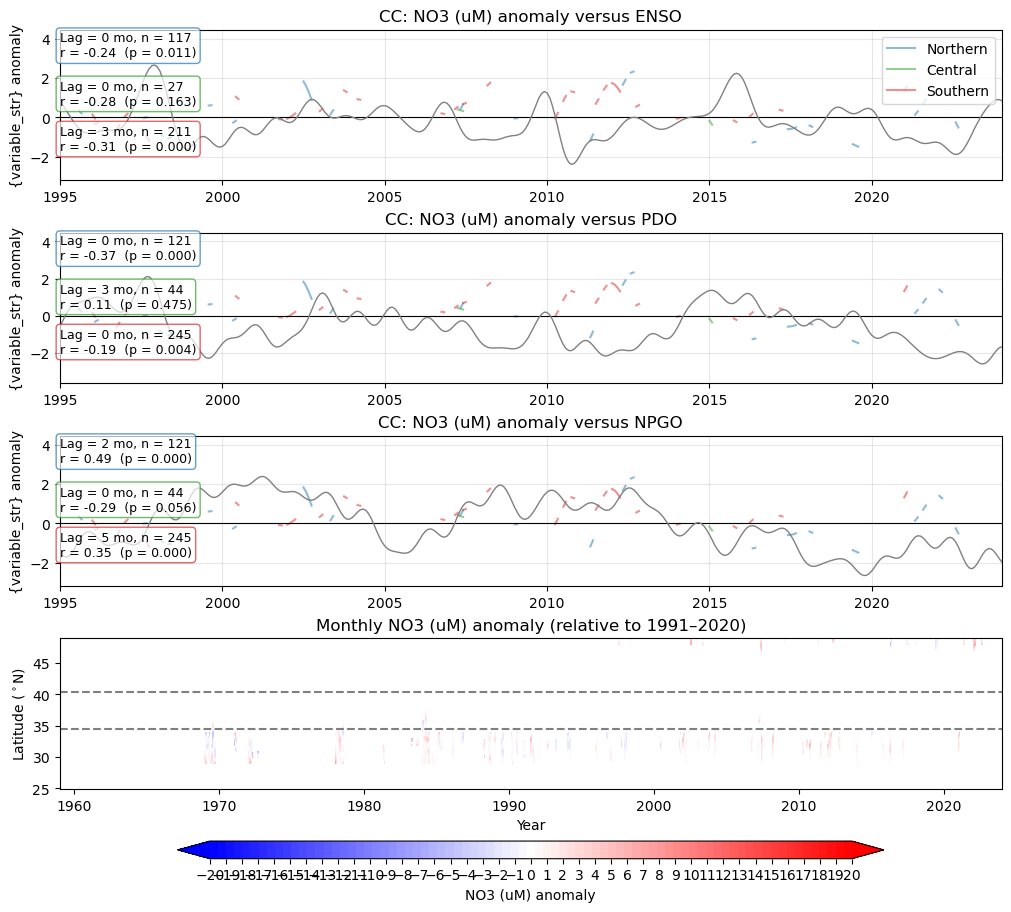

In [91]:
#############
#-- Shelf --#
#############

obs_used = obs_shelf.copy()
variable_str = 'NO3 (uM)'
vmax = 20

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")


#############
#--- CUC ---#
#############

obs_used = obs_cuc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')
# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")


##############
#---- CC ----#
##############
obs_used = obs_cc.copy()
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[2]), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[1]), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(fft_lowpass_monthly(time,anom_array[0]), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('{variable_str} anomaly')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index_lp12']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), enso,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index_lp12']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), pdo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index_lp12']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[2]), npgo,t_month,max_lag_months=6,colour='tab:blue')
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[1]), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], fft_lowpass_monthly(time,anom_array[0]), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Latitude ($^\circ$N)')
ax[3].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
ax[3].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f"{variable_str} anomaly")

ax[0].set_xlim([1995,2024])
ax[1].set_xlim([1995,2024])
ax[2].set_xlim([1995,2024])
# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NorthTAnom.png')

